Imports

In [97]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Check GPU is enabled

In [98]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Wed Jan 24 22:23:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              33W /  70W |   9235MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download training set to your google drive: https://drive.google.com/uc?export=download&id=1HXm4EXXvvd1lZ2SuLZrKT91SiM45ww5r

Load training dataset

In [100]:
# load training dataset
FN = "/content/drive/MyDrive/MarquetteDr/Summer2023/walnut/pythonDL/breast_phantom_512.npy" #put in path to file in drive
images = np.load(FN, mmap_mode = "r") #1000 images
train_images = images[:800] #training set
test_images = images[800:] #test set

# class ImageDataset(torch.utils.data.Dataset):
#     def __init__(self, images):
#         self.images = images

#     def __getitem__(self, idx):
#         return self.images[idx,None,:,:].astype('float32')

#     def __len__(self):
#         return len(self.images)

# dataset = ImageDataset(images)

Define U-net architecture

In [101]:
"""
Copyright (c) Facebook, Inc. and its affiliates.
This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.
"""

import torch
from torch import nn
from torch.nn import functional as F


class ConvBlock(nn.Module):
    """
    A Convolutional Block that consists of two convolution layers each followed by
    instance normalization, LeakyReLU activation and dropout.
    """

    def __init__(self, in_chans, out_chans, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input.
            out_chans (int): Number of channels in the output.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(drop_prob)
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        return self.layers(input)


class TransposeConvBlock(nn.Module):
    """
    A Transpose Convolutional Block that consists of one convolution transpose layers followed by
    instance normalization and LeakyReLU activation.
    """

    def __init__(self, in_chans, out_chans):
        """
        Args:
            in_chans (int): Number of channels in the input.
            out_chans (int): Number of channels in the output.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_chans, out_chans, kernel_size=2, stride=2, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        return self.layers(input)

class ZerosNet(nn.Module):
    def __init__(self):
        super(ZerosNet, self).__init__()

    def forward(self, input):
        return input*0.0 + 0.0

class UnetModel(nn.Module):
    """
    PyTorch implementation of a U-Net model.
    This is based on:
        Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-net: Convolutional networks
        for biomedical image segmentation. In International Conference on Medical image
        computing and computer-assisted intervention, pages 234–241. Springer, 2015.
    """

    def __init__(self, in_chans, out_chans, chans, num_pool_layers, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input to the U-Net model.
            out_chans (int): Number of channels in the output to the U-Net model.
            chans (int): Number of output channels of the first convolution layer.
            num_pool_layers (int): Number of down-sampling and up-sampling layers.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.down_sample_layers = nn.ModuleList([ConvBlock(in_chans, chans, drop_prob)])
        ch = chans
        for i in range(num_pool_layers - 1):
            self.down_sample_layers += [ConvBlock(ch, ch * 2, drop_prob)]
            ch *= 2
        self.conv = ConvBlock(ch, ch * 2, drop_prob)

        self.up_conv = nn.ModuleList()
        self.up_transpose_conv = nn.ModuleList()
        for i in range(num_pool_layers - 1):
            self.up_transpose_conv += [TransposeConvBlock(ch * 2, ch)]
            self.up_conv += [ConvBlock(ch * 2, ch, drop_prob)]
            ch //= 2

        self.up_transpose_conv += [TransposeConvBlock(ch * 2, ch)]
        self.up_conv += [
            nn.Sequential(
                ConvBlock(ch * 2, ch, drop_prob),
                nn.Conv2d(ch, self.out_chans, kernel_size=1, stride=1),
            )]

        self.res = nn.Conv2d(in_chans+out_chans, out_chans, kernel_size=1, padding=0, bias=False)

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        stack = []
        output = input

        # Apply down-sampling layers
        for i, layer in enumerate(self.down_sample_layers):
            output = layer(output)
            stack.append(output)
            output = F.avg_pool2d(output, kernel_size=2, stride=2, padding=0)

        output = self.conv(output)

        # Apply up-sampling layers
        for transpose_conv, conv in zip(self.up_transpose_conv, self.up_conv):
            downsample_layer = stack.pop()
            output = transpose_conv(output)

            # Reflect pad on the right/botton if needed to handle odd input dimensions.
            padding = [0, 0, 0, 0]
            if output.shape[-1] != downsample_layer.shape[-1]:
                padding[1] = 1  # Padding right
            if output.shape[-2] != downsample_layer.shape[-2]:
                padding[3] = 1  # Padding bottom
            if sum(padding) != 0:
                output = F.pad(output, padding, "reflect")

            output = torch.cat([output, downsample_layer], dim=1)
            output = conv(output)

        #concatentate input and output, perform 1x1 convolution (modification by Greg Ongie)
        output = self.res(torch.cat([input,output], dim=1))

        return output

Initialize Unet

In [102]:
net = UnetModel(in_chans=1, out_chans=1, num_pool_layers=4, drop_prob=0.0, chans=32)
net = net.to(device) #send to GPU

Setup Optimizer

In [16]:
optimizer = torch.optim.Adam(net.parameters(),lr=1e-4)

Main training loop

In [103]:
import random

In [104]:
epochs = 1 #number of training epochs (typically 10 or more)
ntrain = 800 #number of training images
std = 0.1 #noise standard deviation to add to training images

loss_fn = torch.nn.MSELoss() #use MSE loss function

for epoch in range(epochs):
  print('epoch ',epoch)
  arr = np.arange(ntrain)
  np.random.shuffle(arr)
  for ind in arr:
    truth_img = torch.from_numpy(train_images[ind]).to(device) #get random training image
    noisy_img = truth_img + (std*random.uniform(0,1))*torch.randn_like(truth_img) #add random Gaussian noise
    denoised_img  = noisy_img - net(noisy_img[None,None,:])[0][0] #unet estimate
    loss = loss_fn(denoised_img, truth_img)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"MSE on current training sample = {loss.item():>4e}")

epoch  0
MSE on current training sample = 8.199627e-03
MSE on current training sample = 7.327294e-03
MSE on current training sample = 7.477455e-03
MSE on current training sample = 6.075534e-03
MSE on current training sample = 6.022664e-03
MSE on current training sample = 8.620898e-03
MSE on current training sample = 6.882473e-03
MSE on current training sample = 7.084307e-03
MSE on current training sample = 6.080335e-03
MSE on current training sample = 7.132635e-03
MSE on current training sample = 8.270143e-03
MSE on current training sample = 7.330270e-03
MSE on current training sample = 6.636550e-03
MSE on current training sample = 6.113730e-03
MSE on current training sample = 6.034342e-03
MSE on current training sample = 6.577045e-03
MSE on current training sample = 6.566474e-03
MSE on current training sample = 6.074147e-03
MSE on current training sample = 8.350232e-03
MSE on current training sample = 6.225221e-03
MSE on current training sample = 7.365012e-03
MSE on current training s

Compute MSE over test set

In [105]:
torch.manual_seed(0) #set random seed for reproducibility
test_loss = 0
ntest = 200
with torch.no_grad(): #turn off gradient computations for speed
  for ind in range(ntest):
    truth_img = torch.from_numpy(test_images[ind]).to(device) #get test image
    noisy_img = truth_img + std*torch.randn_like(truth_img) #add random Gaussian noise
    denoised_img  = net(noisy_img[None,None,:])[0][0] #unet estimate
    test_loss += loss_fn(denoised_img, truth_img)

test_loss = test_loss/ntest
print(f"avg MSE on test set = {test_loss.item():>4e}")

avg MSE on test set = 8.855059e-03


Try out trained denoiser on single test set image

In [106]:
truth_img = torch.from_numpy(train_images[0]).to(device) #get test image
noisy_img = truth_img + std*torch.randn_like(truth_img) #add random Gaussian noise
with torch.no_grad():
  denoised_img  = net(noisy_img[None,None,:])[0][0].detach() #unet estimate

In [107]:
denoised_img.shape

torch.Size([512, 512])

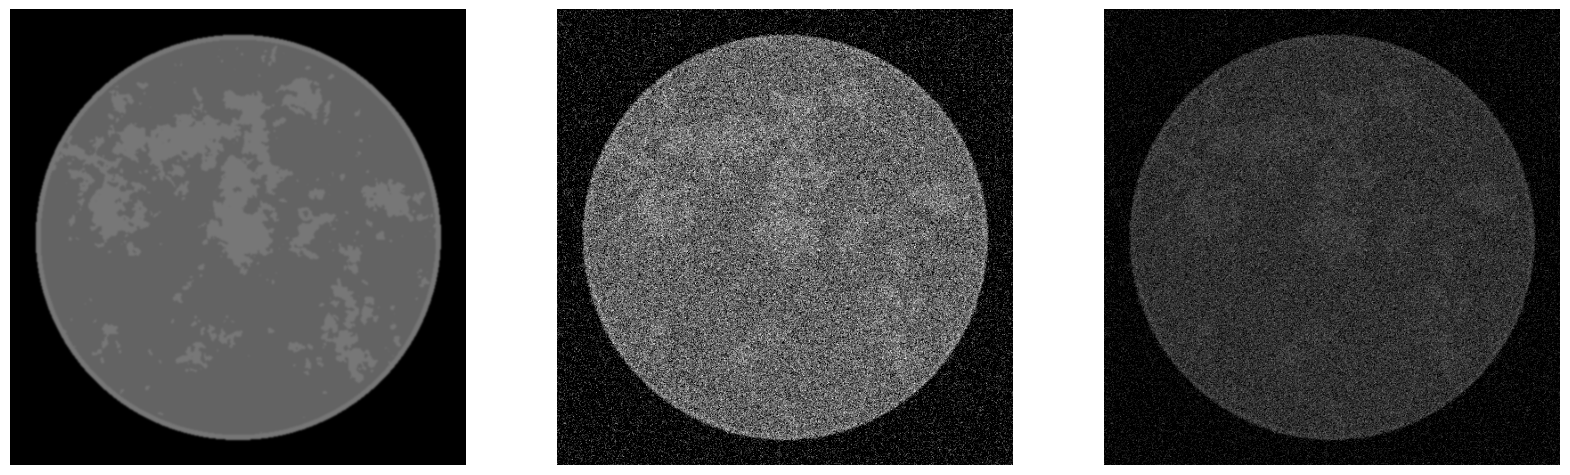

In [108]:
figure = plt.figure(figsize=(20, 10))
cols, rows = 3, 1
figure.add_subplot(rows,cols, 1)
plt.axis("off")
plt.imshow(truth_img.cpu(), cmap="gray",vmin = 0, vmax = 0.5)
figure.add_subplot(rows,cols, 2)
plt.axis("off")
plt.imshow(noisy_img.cpu(), cmap="gray",vmin = 0, vmax = 0.5)
figure.add_subplot(rows,cols, 3)
plt.axis("off")
plt.imshow(denoised_img.cpu(), cmap="gray",vmin = 0, vmax = 0.5)

In [109]:
torch.save(net,'/content/drive/MyDrive/MarquetteDr/Summer2023/walnut/pythonDL/denoiser_net_random_noise.pt')